# Mapping CitiBike Data + ACS by NTA Data

In [340]:
import numpy as np
import pandas as pd
import datetime as dt
from pandas.api.types import CategoricalDtype

import folium
import branca
import fiona
import geopandas as gpd
from shapely.geometry import Point
from matplotlib.colors import Normalize, rgb2hex
import matplotlib.cm as cm

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import matplotlib.dates as mdates
import plotly.graph_objects as go

## Define helper functions

In [2]:
def colpercent(df):
    print("Total NaN in Dataframe: " , df.isnull().sum().sum())
    print("Percent Missingness in Dataframe: ", 100*df.isnull().sum().sum()/(len(df.index)*len(df.columns)))
    print('-'*55)
    percentnulldf = df.isnull().sum()/(df.isnull().sum()+df.notna().sum())
    print("Percent Missingness by Columns:")
    print(100*percentnulldf[percentnulldf>0].sort_values(ascending=False))
    
def data_eval(df):
    for i in range(len(df.columns)):
        print('-'*50)
        print('Column Name: ', df.columns[i])
        if (df[df.columns[i]].dtypes == 'float64' or df[df.columns[i]].dtypes == 'int64') and df[df.columns[i]][df[df.columns[i]]<0].count()>0:
            print('Number of negatives: ', df[df.columns[i]][df[df.columns[i]]<0].count())
        if df[df.columns[i]][df[df.columns[i]]=='None'].count() > 0:
            print('Number of None strings: ', df[df.columns[i]][df[df.columns[i]]=='None'].count())
        if df[df.columns[i]][df[df.columns[i]]==''].count() > 0:
            print('Number of empty strings: ', df[df.columns[i]][df[df.columns[i]]==''].count())
        else:
            print('Column ' + str(i) + ' has no negatives, empty strings or Nones')

In [3]:
def show_all(df):
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', len(df))
    print(df)
    pd.reset_option('display.max_columns')
    pd.reset_option('display.max_rows')

## Import and load data

In [4]:
cbacs_path = '../../data/02_processed/sample_citibike_with_acsnta.csv'

# cbacs_path = '../../data/02_processed/citibike_with_acsnta.csv'

cbacs_raw = pd.read_csv(cbacs_path,
                        parse_dates=['starttime', 'stoptime','birthyear'])

C:\Users\Ivan Passoni\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (34) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
cbacs = cbacs_raw.copy()

## Inspect data frame

Get dimensions of data frame and datatypes of each feature:

In [6]:
cbacs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4015006 entries, 0 to 4015005
Columns: 133 entries, bikeid to end_pop_below_poverty
dtypes: datetime64[ns](3), float64(18), int64(90), object(22)
memory usage: 4.0+ GB


In [7]:
cbacs.columns.values.tolist()

['bikeid',
 'birthyear',
 'endstationid',
 'endstationlatitude',
 'endstationlongitude',
 'endstationname',
 'gender',
 'startstationid',
 'startstationlatitude',
 'startstationlongitude',
 'startstationname',
 'starttime',
 'stoptime',
 'tripduration',
 'usertype',
 'vicentydistance',
 'manhdistance',
 'startmonth',
 'stopmonth',
 'startdayname',
 'startday',
 'stopdayname',
 'stopday',
 'startdaytype',
 'enddaytype',
 'starthour',
 'endhour',
 'startrushhour',
 'endrushhour',
 'starttimeofday',
 'endtimeofday',
 'age_at_ride',
 'age_group',
 'startneighborhood',
 'endneighborhood',
 'startboro',
 'endboro',
 'start_nta_name',
 'start_nta_code',
 'start_borough',
 'start_in_labor_force',
 'start_civilian_labor_force',
 'start_employed',
 'start_unemployed',
 'start_armed_forces',
 'start_not_in_labor_force',
 'start_workers_16+',
 'start_vehicle',
 'start_carpool',
 'start_public_transit',
 'start_walking',
 'start_other_commuting_means',
 'start_work_at_home',
 'start_mean_commuting_

In [8]:
cbacs.rename(columns={'end_mean_commuting_time_(min)':'end_mean_commuting_time_in_min',
                     'start_mean_commuting_time_(min)':'start_mean_commuting_time_in_min'}, inplace=True)

Randomly sample five observations:

In [9]:
cbacs.sample(n=5)

,bikeid,birthyear,endstationid,endstationlatitude,endstationlongitude,endstationname,gender,startstationid,startstationlatitude,startstationlongitude,...,end_hincome_200K_more,end_median_hincome,end_mean_hincome,end_median_earnings,end_median_earnings_male,end_median_earnings_female,end_all_families,end_all_families_below_poverty,end_pop_poverty_status_determ,end_pop_below_poverty
3183004,16103,1986-01-01,3158,40.771639,-73.982614,W 63 St & Broadway,1,305,40.760958,-73.967245,...,11368,130237.0,218554.0,100000.0,100000.0,100000.0,13744,709,61197,5101
2448533,22614,1900-01-01,164,40.753231,-73.970325,E 47 St & 2 Ave,0,225,40.741951,-74.008030,...,9734,136326.0,223563.0,97935.0,100000.0,97271.0,10389,129,49671,2246
2266897,29113,1987-01-01,439,40.726281,-73.989780,E 4 St & 2 Ave,1,504,40.732219,-73.981656,...,3676,77691.0,118140.0,62054.0,93912.0,73252.0,5589,543,37633,6485
3107080,19756,1982-01-01,521,40.750450,-73.994811,8 Ave & W 31 St,1,474,40.745168,-73.986831,...,12898,114710.0,189927.0,90085.0,100000.0,95378.0,13409,919,75475,9129
1903930,20028,1949-01-01,259,40.701221,-74.012342,South St & Whitehall St,2,3701,40.708318,-74.005041,...,8757,162555.0,214165.0,98642.0,100000.0,93897.0,9373,338,44606,3044


Check for missing values:

In [10]:
colpercent(cbacs)

Total NaN in Dataframe:  828552
Percent Missingness in Dataframe:  0.15516077150854285
-------------------------------------------------------
Percent Missingness by Columns:
endneighborhood      6.918944
startboro            6.858720
startneighborhood    6.858720
dtype: float64


In [11]:
null_df = cbacs[cbacs.isnull().any(axis=1)]

Examine missing values for `endneighborhood`, `startboro`, and `startneighborhood`:

In [12]:
null_df[['endstationname','endboro','end_nta_name','endneighborhood','endstationid',
         'startstationname','startboro','start_nta_name','startneighborhood','startstationid']]

,endstationname,endboro,end_nta_name,endneighborhood,endstationid,startstationname,startboro,start_nta_name,startneighborhood,startstationid
332,MacDougal St & Washington Sq,Manhattan,West Village,Greenwich Village,252,W 33 St & 7 Ave,NaN,Midtown-Midtown South,NaN,492
333,MacDougal St & Washington Sq,Manhattan,West Village,Greenwich Village,252,W 33 St & 7 Ave,NaN,Midtown-Midtown South,NaN,492
334,MacDougal St & Washington Sq,Manhattan,West Village,Greenwich Village,252,W 33 St & 7 Ave,NaN,Midtown-Midtown South,NaN,492
335,MacDougal St & Washington Sq,Manhattan,West Village,Greenwich Village,252,W 33 St & 7 Ave,NaN,Midtown-Midtown South,NaN,492
336,MacDougal St & Washington Sq,Manhattan,West Village,Greenwich Village,252,W 33 St & 7 Ave,NaN,Midtown-Midtown South,NaN,492
...,...,...,...,...,...,...,...,...,...,...
4012744,NYCBS Depot - GOW,Manhattan,Park Slope-Gowanus,Kings County,3432,5 Ave & E 88 St,NaN,park-cemetery-etc-Manhattan,NaN,3282
4013290,Steinway St & 28 Ave,Manhattan,Astoria,Steinway,3616,W 34 St & 11 Ave,NaN,Hudson Yards-Chelsea-Flat Iron-Union Square,NaN,525
4014645,Smart Cities Conference,Manhattan,Lower East Side,Stuy Town,3683,St James Pl & Oliver St,NaN,Chinatown,NaN,308
4014708,Evergreen Ave & Noll St,Manhattan,Bushwick South,Bushwick,3821,E 30 St & Park Ave S,NaN,Murray Hill-Kips Bay,NaN,546


Check for missing incorrectly entered or weird values:

In [13]:
data_eval(cbacs)

--------------------------------------------------
Column Name:  bikeid
Column 0 has no negatives, empty strings or Nones
--------------------------------------------------
Column Name:  birthyear
Column 1 has no negatives, empty strings or Nones
--------------------------------------------------
Column Name:  endstationid
Column 2 has no negatives, empty strings or Nones
--------------------------------------------------
Column Name:  endstationlatitude
Column 3 has no negatives, empty strings or Nones
--------------------------------------------------
Column Name:  endstationlongitude


C:\Users\Ivan Passoni\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


Number of negatives:  4015006
Column 4 has no negatives, empty strings or Nones
--------------------------------------------------
Column Name:  endstationname
Column 5 has no negatives, empty strings or Nones
--------------------------------------------------
Column Name:  gender
Column 6 has no negatives, empty strings or Nones
--------------------------------------------------
Column Name:  startstationid
Column 7 has no negatives, empty strings or Nones
--------------------------------------------------
Column Name:  startstationlatitude
Column 8 has no negatives, empty strings or Nones
--------------------------------------------------
Column Name:  startstationlongitude
Number of negatives:  4015006
Column 9 has no negatives, empty strings or Nones
--------------------------------------------------
Column Name:  startstationname
Column 10 has no negatives, empty strings or Nones
--------------------------------------------------
Column Name:  starttime
Column 11 has no negatives,

Column 68 has no negatives, empty strings or Nones
--------------------------------------------------
Column Name:  start_hincome_25K_35K
Column 69 has no negatives, empty strings or Nones
--------------------------------------------------
Column Name:  start_hincome_35K_50K
Column 70 has no negatives, empty strings or Nones
--------------------------------------------------
Column Name:  start_hincome_50K_75K
Column 71 has no negatives, empty strings or Nones
--------------------------------------------------
Column Name:  start_hincome_75K_100K
Column 72 has no negatives, empty strings or Nones
--------------------------------------------------
Column Name:  start_hincome_100K_150K
Column 73 has no negatives, empty strings or Nones
--------------------------------------------------
Column Name:  start_hincome_150K_200K
Column 74 has no negatives, empty strings or Nones
--------------------------------------------------
Column Name:  start_hincome_200K_more
Column 75 has no negatives,

Adjust `tripduration`:

In [14]:
cbacs['tripduration'] = cbacs['tripduration'].abs()

Drop improbable ages:

In [15]:
cbacs.drop(cbacs['age_at_ride'].loc[cbacs['age_at_ride'] >= 100].index, inplace=True)
# cbacs['age_at_ride'].loc[cbacs['age_at_ride'] >= 100]

## Data preprocessing

### Perform datatype conversions

In [16]:
num_nom_feat = ['bikeid','endstationid','startstationid','gender','age_at_ride','startday']
cat_nom_feat = ['start_nta_code','end_nta_code','start_nta_name','end_nta_name',
                'endstationname','startstationname','usertype',
               'startneighborhood','start_borough','endneighborhood','end_borough',
               'startdayname','stopdayname','startdaytype','enddaytype','startrushhour',
                'endrushhour','starttimeofday','endtimeofday','age_group']

In [17]:
cbacs['birthyear'] = pd.to_datetime(cbacs.birthyear, format='%Y')

In [18]:
cbacs[cat_nom_feat] = cbacs[cat_nom_feat].apply(lambda x: x.astype('category'))

## Feature engineering

Create new feature to get a sense of flow between boroughs:

In [19]:
boro_plus_dict = {'Manhattan': 'Manhattan', 
                  'Brooklyn': 'Outer Borough',
                  'Bronx': 'Outer Borough',
                  'Queens': 'Outer Borough', 
                  'Jersey City': 'Tri-State Area'}

In [20]:
cbacs['start_boro_flow'] = cbacs.start_borough.map(boro_plus_dict)
cbacs['end_boro_flow'] = cbacs.end_borough.map(boro_plus_dict)

Reorder time feature:

In [21]:
cbacs['startrushhour'].cat.set_categories(['Morning Off-Peak','Morning Rush','Afternoon Off-Peak',
                                           'Afternoon Rush','Evening Off-Peak'],inplace=True)

In [22]:
cbacs['endrushhour'].cat.set_categories(['Morning Off-Peak','Morning Rush','Afternoon Off-Peak',
                                         'Afternoon Rush','Evening Off-Peak'],inplace=True)

In [23]:
cbacs['startdayname'].cat.set_categories(['Monday','Tuesday','Wednesday','Thursday',
                                         'Friday','Saturday','Sunday'],inplace=True)

In [24]:
cbacs['stopdayname'].cat.set_categories(['Monday','Tuesday','Wednesday','Thursday',
                                         'Friday','Saturday','Sunday'],inplace=True)

Exclude out-of-bounds neighborhoods:

In [25]:
cbacs = cbacs[~cbacs['startneighborhood'].isin(['New York County','Kings County','Queens County'])]
cbacs = cbacs[~cbacs['endneighborhood'].isin(['New York County','Kings County','Queens County'])]
cbacs = cbacs[~cbacs['startboro'].isin(['Jersey City'])]
cbacs = cbacs[~cbacs['endboro'].isin(['Jersey City'])]

Save:

In [26]:
# cbacs.to_pickle('../../data/02_processed/citibike_acsnta201418.pkl')

## Data visualization

### Maps

Subset data set for geospatial mapping:

In [28]:
nta_shp = '../../data/00_raw/NTA_map.geojson'
acsnta_path = '../../data/00_raw/acsnta.csv'

# nta_shp = 'NTA_map.geojson'
# acsnta_path = 'acsnta.csv'

In [29]:
nta_df = pd.read_csv(acsnta_path)
nta_df.loc[nta_df['mean_hincome'] == 0, 'mean_hincome'] = np.mean(nta_df['mean_hincome'])

In [30]:
start_stations = cbacs.groupby('startstationid').agg({'startstationlatitude':'mean', 
                                                      'startstationlongitude':'mean', 
                                                      'tripduration':'mean',
                                                      'start_mean_hincome':'mean',
                                                      'bikeid':'count'}).merge(cbacs[['startstationid',
                                                                                      'startstationname',
                                                                                      'start_nta_name']], 
                                          on='startstationid', how='left').drop_duplicates('startstationid')
start_stations = start_stations.rename(columns={'bikeid':'start_count'})

In [31]:
start_stations = start_stations[start_stations['start_count'] > 100]

In [32]:
# normalize trip counts to color
norm = Normalize(start_stations['start_count'].min(), start_stations['start_count'].max())

In [33]:
station_map = folium.Map(location=[40.75, -74.0001],
               tiles = 'CartoDB Dark_matter',
               zoom_start=12)

In [34]:
folium.TileLayer('CartoDB positron').add_to(station_map)

folium.Choropleth(
    geo_data=nta_shp,
    name='chp',
    data=nta_df,
    columns=['nta_code','mean_hincome'],
    key_on='feature.properties.ntacode',
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=1,
    legend_name='Mean Household Income ($)'
).add_to(station_map);

for idx, row in start_stations.iterrows():
    color = rgb2hex(cm.OrRd(norm(row['start_count'])+0.3))
    folium.CircleMarker(location=[row['startstationlatitude'], row['startstationlongitude']],
                        popup=row['startstationname'],
                        fill=True,
                        radius = row['tripduration']/300,
                        color=color, 
                        fill_color=color,
                        fill_opacity=1.0).add_to(station_map)
    
folium.LayerControl().add_to(station_map);

What each part of the map represents:

- Markers for each station
    - Size represents `tripduration`
    - Color represents station utilization; darker colors indicate higher utilization
- Chorolpleths for each NTA
    - Color represents mean income of NTA

In [35]:
station_map.save('cb_nta_map.html')

In [37]:
cbacs['startyear'] = cbacs['starttime'].dt.year

In [38]:
trip_count_year = cbacs.groupby('startyear').agg('count')[['bikeid']].rename(columns={'bikeid':'Trip Count'})

In [39]:
trip_count_year = trip_count_year.drop(index=2020)

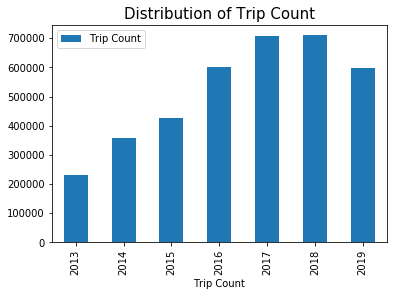

In [40]:
trip_count_year.reset_index().plot(kind='bar', x = 'startyear')
plt.title('Distribution of Trip Count',fontsize=15)
plt.xlabel('Trip Count')
plt.show();

### Tables

In [41]:
perc_rides_by_boro_flow = cbacs.pivot_table('bikeid', index='start_boro_flow', columns='end_boro_flow', aggfunc=len, fill_value=0).div(len(cbacs.bikeid)).mul(100)
perc_rides_by_boro_flow = perc_rides_by_boro_flow.applymap('{0:,.1f}%'.format)
perc_rides_by_boro_flow

end_boro_flow,Manhattan,Outer Borough
start_boro_flow,,
Manhattan,84.0%,2.0%
Outer Borough,1.9%,12.1%


In [42]:
avg_rides_by_boro_triptime1 = cbacs.pivot_table('tripduration', index=['start_boro_flow', 'end_boro_flow'],  aggfunc='mean', fill_value=0).div(60)
avg_rides_by_boro_triptime1 = avg_rides_by_boro_triptime1.applymap('{0:,.0f} min'.format)
avg_rides_by_boro_triptime1

tripduration
start_boro_flow end_boro_flow             
Manhattan       Manhattan           13 min
                Outer Borough       28 min
Outer Borough   Manhattan           27 min
                Outer Borough       11 min

In [43]:
avg_rides_by_boro_triptime = cbacs.pivot_table('tripduration', index=['start_boro_flow', 'end_boro_flow'], columns='startdaytype', aggfunc='mean', fill_value=0).div(60)
avg_rides_by_boro_triptime = avg_rides_by_boro_triptime.applymap('{0:,.0f} min'.format)
avg_rides_by_boro_triptime

startdaytype                  Weekday Weekend
start_boro_flow end_boro_flow                
Manhattan       Manhattan      12 min  14 min
                Outer Borough  27 min  29 min
Outer Borough   Manhattan      26 min  28 min
                Outer Borough  10 min  13 min

In [44]:
avg_rides_by_boro_mandist = cbacs.pivot_table('manhdistance', index=['start_boro_flow', 'end_boro_flow'], aggfunc='mean', fill_value=0)
avg_rides_by_boro_mandist = avg_rides_by_boro_mandist.applymap('{0:,.2f} miles'.format)
avg_rides_by_boro_mandist

manhdistance
start_boro_flow end_boro_flow             
Manhattan       Manhattan       1.37 miles
                Outer Borough   3.27 miles
Outer Borough   Manhattan       3.27 miles
                Outer Borough   1.13 miles

In [45]:
outflow_nta = cbacs.pivot_table('bikeid', index='start_nta_name', aggfunc='count', fill_value = 0) # Origin => Positive Net Outflow
inflow_nta = cbacs.pivot_table('bikeid', index='end_nta_name', aggfunc='count', fill_value = 0) # Destination => Positive Net Inflow

# Drop misc category
outflow_nta.drop(index = [idx for idx in outflow_nta.index if 'park-cemetery' in idx], inplace=True)
inflow_nta.drop(index = [idx for idx in inflow_nta.index if 'park-cemetery' in idx], inplace=True)

# Origin
outflow_nta_origin = outflow_nta - inflow_nta
outflow_nta_origin.columns = ['Net Outflow of Rides']
outflow_nta_origin.index.names = ['Neighborhood Tabulation Area']

# Destination
inflow_nta_dest = inflow_nta - outflow_nta
inflow_nta_dest.columns = ['Net Inflow of Rides']
inflow_nta_dest.index.names = ['Neighborhood Tabulation Area']

In [46]:
top5_nta_outflow = outflow_nta_origin.sort_values(['Net Outflow of Rides'], ascending=False).dropna().head(5)
top5_nta_outflow

,Net Outflow of Rides
Neighborhood Tabulation Area,
Murray Hill-Kips Bay,5731
Upper West Side,5654
Lincoln Square,4842
Midtown-Midtown South,4742
Clinton,3767


In [47]:
top5_nta_inflow = inflow_nta_dest.sort_values(['Net Inflow of Rides'], ascending=False).dropna().head(5)
top5_nta_inflow.index.names = ['Neighborhood Tabulation Area']
top5_nta_inflow

,Net Inflow of Rides
Neighborhood Tabulation Area,
SoHo-TriBeCa-Civic Center-Little Italy,9523
Hudson Yards-Chelsea-Flat Iron-Union Square,6735
Battery Park City-Lower Manhattan,6161
West Village,6095
DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,3707


`Hudson Yards-Chelsea-Flat Iron-Union Square` is a popular weekday and weekend NTA:

In [48]:
mean_nta_startdaytype = cbacs.pivot_table('bikeid', index='start_nta_name', columns='startdaytype', aggfunc=len, fill_value=0).div(len(cbacs.bikeid)).mul(100)
mean_nta_startdaytype = mean_nta_startdaytype.applymap('{0:,.2f}%'.format)
show_all(mean_nta_startdaytype)

startdaytype                                     Weekday Weekend
start_nta_name                                                  
Astoria                                            0.20%   0.09%
Battery Park City-Lower Manhattan                  4.05%   1.03%
Bedford                                            0.34%   0.15%
Brooklyn Heights-Cobble Hill                       0.71%   0.24%
Bushwick North                                     0.02%   0.01%
Bushwick South                                     0.07%   0.04%
Carroll Gardens-Columbia Street-Red Hook           0.46%   0.20%
Central Harlem North-Polo Grounds                  0.05%   0.02%
Central Harlem South                               0.22%   0.09%
Chinatown                                          2.65%   0.99%
Clinton                                            3.17%   0.84%
Clinton Hill                                       0.61%   0.23%
Crown Heights North                                0.09%   0.04%
Crown Heights South      

In [49]:
mean_nta_enddaytype = cbacs.pivot_table('bikeid', index='end_nta_name', columns='enddaytype', aggfunc=len, fill_value=0).div(len(cbacs.bikeid)).mul(100)
mean_nta_enddaytype = mean_nta_enddaytype.applymap('{0:,.2f}%'.format)
show_all(mean_nta_enddaytype)

enddaytype                                       Weekday Weekend
end_nta_name                                                    
Astoria                                            0.20%   0.09%
Battery Park City-Lower Manhattan                  4.17%   1.08%
Bedford                                            0.35%   0.14%
Brooklyn Heights-Cobble Hill                       0.66%   0.24%
Bushwick North                                     0.02%   0.01%
Bushwick South                                     0.08%   0.04%
Carroll Gardens-Columbia Street-Red Hook           0.48%   0.21%
Central Harlem North-Polo Grounds                  0.05%   0.02%
Central Harlem South                               0.23%   0.09%
Chinatown                                          2.64%   1.01%
Clinton                                            3.10%   0.81%
Clinton Hill                                       0.55%   0.20%
Crown Heights North                                0.09%   0.04%
Crown Heights South      

In [50]:
mean_nb_startdaytype = cbacs.pivot_table('bikeid', index='startneighborhood', columns='startdaytype', aggfunc=len, fill_value=0).div(len(cbacs.bikeid)).mul(100)
mean_nb_startdaytype = mean_nb_startdaytype.applymap('{0:,.2f}%'.format)
show_all(mean_nb_startdaytype)

startdaytype                        Weekday Weekend
startneighborhood                                  
Alphabet City                         1.26%   0.46%
Astoria                               0.25%   0.10%
Battery Park City                     1.54%   0.49%
Bay Ridge                             0.02%   0.01%
Bedford-Stuyvesant                    0.34%   0.14%
Bergen                                0.15%   0.06%
Boerum Hill                           0.30%   0.11%
Broadway                              5.73%   1.36%
Brooklyn Heights                      0.52%   0.18%
Brooklyn Navy Yard                    0.03%   0.00%
Bushwick                              0.09%   0.05%
Carnegie Hill                         0.13%   0.04%
Chelsea                               7.67%   1.91%
Chinatown                             0.63%   0.24%
Clinton Hill                          0.51%   0.18%
Cobble Hill                           0.33%   0.11%
Columbia Street Waterfront District   0.12%   0.06%
Columbus Cir

Traffic flow at popular weekday/weekend destination:

In [51]:
outflow_nta_rush = cbacs.pivot_table('bikeid', index='start_nta_name', columns='startrushhour', aggfunc='count', fill_value = 0) # Origin => Positive Net Outflow
inflow_nta_rush = cbacs.pivot_table('bikeid', index='end_nta_name', columns='endrushhour', aggfunc='count', fill_value = 0) # Destination => Positive Net Inflow

# Drop misc category
outflow_nta_rush.drop(index = [idx for idx in outflow_nta.index if 'park-cemetery' in idx], inplace=True)
outflow_nta_rush.drop(index = [idx for idx in inflow_nta.index if 'park-cemetery' in idx], inplace=True)

# Origin - Net Outflow of Rides
outflow_nta_rush_orig = outflow_nta_rush - inflow_nta_rush
outflow_nta_rush_orig.index.names = ['Neighborhood Tabulation Area']

# Destination - Net Inflow of Rides
inflow_nta_rush_dest = inflow_nta_rush - outflow_nta_rush
inflow_nta_rush_dest.index.names = ['Neighborhood Tabulation Area']

More outgoing trips on afternoon rush and evening off-peak hours:

In [52]:
chelsea_outgoingt_rush = outflow_nta_rush_orig.loc[outflow_nta_rush_orig.index == 'Hudson Yards-Chelsea-Flat Iron-Union Square']
chelsea_outgoingt_rush

startrushhour,Morning Off-Peak,Morning Rush,Afternoon Off-Peak,Afternoon Rush,Evening Off-Peak
Neighborhood Tabulation Area,,,,,
Hudson Yards-Chelsea-Flat Iron-Union Square,-143,-13139,-5432,10128,1851


Popular destination in morning and afternoon hours:

In [53]:
chelsea_incomingt_rush = inflow_nta_rush_dest.loc[inflow_nta_rush_dest.index == 'Hudson Yards-Chelsea-Flat Iron-Union Square']
chelsea_incomingt_rush

endrushhour,Morning Off-Peak,Morning Rush,Afternoon Off-Peak,Afternoon Rush,Evening Off-Peak
Neighborhood Tabulation Area,,,,,
Hudson Yards-Chelsea-Flat Iron-Union Square,143,13139,5432,-10128,-1851


In [54]:
outflow_nta_day = cbacs.pivot_table('bikeid', index='start_nta_name', columns='startdayname', aggfunc='count', fill_value = 0) # Origin => Positive Net Outflow
inflow_nta_day = cbacs.pivot_table('bikeid', index='end_nta_name', columns='stopdayname', aggfunc='count', fill_value = 0) # Destination => Positive Net Inflow

# Drop misc category
outflow_nta_day.drop(index = [idx for idx in outflow_nta.index if 'park-cemetery' in idx], inplace=True)
inflow_nta_day.drop(index = [idx for idx in inflow_nta.index if 'park-cemetery' in idx], inplace=True)

# Origin - Net Outflow of Rides
outflow_nta_day_orig = outflow_nta_day - inflow_nta_day
outflow_nta_day_orig.index.names = ['Neighborhood Tabulation Area']

# Destination - Net Inflow of Rides
inflow_nta_day_dest = inflow_nta_day - outflow_nta_day
inflow_nta_day_dest.index.names = ['Neighborhood Tabulation Area']

More outgoing traffic on Tuesday (??):

In [55]:
chelsea_outgoingt_day = outflow_nta_day_orig.loc[outflow_nta_day_orig.index == 'Hudson Yards-Chelsea-Flat Iron-Union Square']
chelsea_outgoingt_day

startdayname,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Neighborhood Tabulation Area,,,,,,,
Hudson Yards-Chelsea-Flat Iron-Union Square,112,-852,-1145,-839,-1101,-2050,-860


Unsurprisingly, more incoming traffic on Fridays and weekends:

In [56]:
chelsea_incomingt_day = inflow_nta_day_dest.loc[inflow_nta_day_dest.index == 'Hudson Yards-Chelsea-Flat Iron-Union Square']
chelsea_incomingt_day

stopdayname,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Neighborhood Tabulation Area,,,,,,,
Hudson Yards-Chelsea-Flat Iron-Union Square,-112,852,1145,839,1101,2050,860


More stats on Chelsea area:

In [57]:
count_nb_startdaytype = cbacs.pivot_table('bikeid', index='start_nta_name', columns='startdaytype', aggfunc='count', fill_value=0)
count_nb_startdaytype = count_nb_startdaytype.applymap('{0:,.0f}'.format)
count_nb_startdaytype.loc[count_nb_startdaytype.index == 'Hudson Yards-Chelsea-Flat Iron-Union Square']

startdaytype,Weekday,Weekend
start_nta_name,,
Hudson Yards-Chelsea-Flat Iron-Union Square,"372,599","97,919"


In [58]:
count_nb_enddaytype = cbacs.pivot_table('bikeid', index='end_nta_name', columns='enddaytype', aggfunc='count', fill_value=0)
count_nb_enddaytype = count_nb_enddaytype.applymap('{0:,.0f}'.format)
count_nb_enddaytype.loc[count_nb_enddaytype.index == 'Hudson Yards-Chelsea-Flat Iron-Union Square']

enddaytype,Weekday,Weekend
end_nta_name,,
Hudson Yards-Chelsea-Flat Iron-Union Square,"376,517","100,736"


Outflow by demographics:

In [59]:
outflow_hood = cbacs.pivot_table('bikeid', index='start_nta_name', columns='startdaytype', aggfunc='count', fill_value = 0)
inflow_hood = cbacs.pivot_table('bikeid', index='end_nta_name', columns='enddaytype', aggfunc='count', fill_value = 0)

# Origin
net_outflow_day = outflow_hood - inflow_hood
net_outflow_day.columns.names = ['Day Type']
net_outflow_day.index.names = ['NTA']

# Destination
net_inflow_day = inflow_hood - outflow_hood
net_inflow_day.columns.names = ['Day Type']
net_inflow_day.index.names = ['NTA']

In [60]:
net_outflow_day.loc[net_outflow_day.index == 'Hudson Yards-Chelsea-Flat Iron-Union Square']

Day Type,Weekday,Weekend
NTA,,
Hudson Yards-Chelsea-Flat Iron-Union Square,-3918,-2817


In [61]:
outflow_gender = cbacs.pivot_table('bikeid', index='start_nta_name', columns='gender', aggfunc='count', fill_value = 0)
inflow_gender = cbacs.pivot_table('bikeid', index='end_nta_name',  columns='gender', aggfunc='count', fill_value = 0)

# Origin
net_outflow_gender = outflow_gender - inflow_gender
net_outflow_gender.columns = ['Unknown','Male','Female']
net_outflow_gender.drop(columns=['Unknown'], inplace=True)
net_outflow_gender.index.names = ['NTA']

# Destination
net_inflow_gender = inflow_gender - outflow_gender
net_inflow_gender.columns = ['Unknown','Male','Female']
net_inflow_gender.drop(columns=['Unknown'], inplace=True)
net_inflow_gender.index.names = ['NTA']

In [62]:
net_outflow_gender.loc[net_outflow_gender.index == 'Hudson Yards-Chelsea-Flat Iron-Union Square']

,Male,Female
NTA,,
Hudson Yards-Chelsea-Flat Iron-Union Square,-2868,-3612


In [63]:
outflow_age = cbacs.pivot_table('bikeid', index='start_nta_name', columns='age_group', aggfunc='count', fill_value = 0)
inflow_age = cbacs.pivot_table('bikeid', index='end_nta_name',  columns='age_group', aggfunc='count', fill_value = 0)

net_inflow_age = inflow_age - outflow_age
net_inflow_age.index.names = ['NTA']

net_outflow_age = outflow_age - inflow_age
net_outflow_age.index.names = ['NTA']

In [64]:
net_outflow_age.loc[net_outflow_age.index == 'Hudson Yards-Chelsea-Flat Iron-Union Square']

age_group,20s,30s,40s,50s,60s+,Teens (16-19)
NTA,,,,,,
Hudson Yards-Chelsea-Flat Iron-Union Square,-3446,-2632,-591,-207,122,19


In [65]:
outflow_user = cbacs.pivot_table('bikeid', index='start_nta_name', columns='usertype', aggfunc='count', fill_value = 0)
inflow_user = cbacs.pivot_table('bikeid', index='end_nta_name',  columns='usertype', aggfunc='count', fill_value = 0)

# Origin
net_outflow_user = outflow_user - inflow_user
net_outflow_user.drop(columns=['Unknown'], inplace=True)
net_outflow_user.index.names = ['NTA']

# Destination
net_inflow_user = inflow_user - outflow_user
net_inflow_user.drop(columns=['Unknown'], inplace=True)
net_inflow_user.index.names = ['NTA']

In [66]:
net_outflow_user[net_outflow_user.index == 'Hudson Yards-Chelsea-Flat Iron-Union Square']

usertype,Customer,Subscriber
NTA,,
Hudson Yards-Chelsea-Flat Iron-Union Square,-100,-6654


Inflow by demographics:

In [67]:
net_inflow_day.loc[net_inflow_day.index == 'Hudson Yards-Chelsea-Flat Iron-Union Square']

Day Type,Weekday,Weekend
NTA,,
Hudson Yards-Chelsea-Flat Iron-Union Square,3918,2817


In [68]:
net_inflow_gender.loc[net_inflow_gender.index == 'Hudson Yards-Chelsea-Flat Iron-Union Square']

,Male,Female
NTA,,
Hudson Yards-Chelsea-Flat Iron-Union Square,2868,3612


In [69]:
net_inflow_age.loc[net_inflow_age.index == 'Hudson Yards-Chelsea-Flat Iron-Union Square']

age_group,20s,30s,40s,50s,60s+,Teens (16-19)
NTA,,,,,,
Hudson Yards-Chelsea-Flat Iron-Union Square,3446,2632,591,207,-122,-19


In [70]:
net_inflow_user[net_inflow_user.index == 'Hudson Yards-Chelsea-Flat Iron-Union Square']

usertype,Customer,Subscriber
NTA,,
Hudson Yards-Chelsea-Flat Iron-Union Square,100,6654


#### Neighborhood Tabulation Area American Community Survey Stats: Economy

NTA economic stats:

In [71]:
nta_stats_employ = cbacs.drop_duplicates(subset='start_nta_code')[['start_nta_name','start_civilian_labor_force','start_employed','start_unemployed']]
nta_stats_commute = cbacs.drop_duplicates(subset='start_nta_code')[['start_nta_name','start_workers_16+','start_vehicle','start_carpool',
                               'start_public_transit','start_walking','start_other_commuting_means',
                               'start_work_at_home']]
nta_stats_sector = cbacs.drop_duplicates(subset='start_nta_code')[['start_nta_name','start_occ_civilian_employed_16+','start_mng_biz_sci_arts',
                              'start_service','start_sales_office','start_natres_construct_maint',
                              'start_prod_transport_moving']]
nta_stats_typework = cbacs.drop_duplicates(subset='start_nta_code')[['start_nta_name','start_class_civilian_employed_16+','start_salary_workers',
                                'start_govt_workers','start_self-employed','start_unpaid_family_workers']]
nta_stats_income_brac = cbacs.drop_duplicates(subset='start_nta_code')[['start_nta_name', 'start_total_households','start_hincome_10K_under',
                                   'start_hincome_10K_15K','start_hincome_15K_25K','start_hincome_25K_35K','start_hincome_35K_50K','start_hincome_50K_75K','start_hincome_75K_100K',
                                       'start_hincome_100K_150K','start_hincome_150K_200K','start_hincome_200K_more',]]
nta_stats_income = cbacs.drop_duplicates(subset='start_nta_code')[['start_nta_name','start_mean_hincome','start_all_families',
                              'start_all_families_below_poverty']]
nta_stats_income_brac = cbacs.drop_duplicates(subset='start_nta_code')[['start_nta_name', 'start_total_households','start_hincome_10K_under',
                                   'start_hincome_10K_15K','start_hincome_15K_25K','start_hincome_25K_35K',
                                   'start_hincome_35K_50K','start_hincome_50K_75K','start_hincome_75K_100K',
                                   'start_hincome_100K_150K','start_hincome_150K_200K','start_hincome_200K_more']]

In [72]:
nta_stats_employ['perc_employed'] = nta_stats_employ['start_employed']/nta_stats_employ['start_civilian_labor_force']
nta_stats_employ['perc_unemployed'] = nta_stats_employ['start_unemployed']/nta_stats_employ['start_civilian_labor_force']

nta_stats_commute['perc_car_van_truck'] = nta_stats_commute['start_vehicle']/nta_stats_commute['start_workers_16+']
nta_stats_commute['perc_carpool'] = nta_stats_commute['start_carpool']/nta_stats_commute['start_workers_16+']
nta_stats_commute['perc_public_transit'] = nta_stats_commute['start_public_transit']/nta_stats_commute['start_workers_16+']
nta_stats_commute['perc_walking'] = nta_stats_commute['start_walking']/nta_stats_commute['start_workers_16+']
nta_stats_commute['perc_other_commuting_means'] = nta_stats_commute['start_other_commuting_means']/nta_stats_commute['start_workers_16+']
nta_stats_commute['perc_work_at_home'] = nta_stats_commute['start_work_at_home']/nta_stats_commute['start_workers_16+']

nta_stats_sector['perc_mng_biz_sci_arts'] = nta_stats_sector['start_mng_biz_sci_arts']/nta_stats_sector['start_occ_civilian_employed_16+']
nta_stats_sector['perc_service'] = nta_stats_sector['start_service']/nta_stats_sector['start_occ_civilian_employed_16+']
nta_stats_sector['perc_sales_office'] = nta_stats_sector['start_sales_office']/nta_stats_sector['start_occ_civilian_employed_16+']
nta_stats_sector['perc_natres_construct_maint'] = nta_stats_sector['start_natres_construct_maint']/nta_stats_sector['start_occ_civilian_employed_16+']
nta_stats_sector['perc_prod_transport_moving'] = nta_stats_sector['start_prod_transport_moving']/nta_stats_sector['start_occ_civilian_employed_16+']

nta_stats_typework['perc_salary_workers'] = nta_stats_typework['start_salary_workers']/nta_stats_typework['start_class_civilian_employed_16+']
nta_stats_typework['perc_govt_workers'] = nta_stats_typework['start_govt_workers']/nta_stats_typework['start_class_civilian_employed_16+']
nta_stats_typework['perc_self-employed'] = nta_stats_typework['start_self-employed']/nta_stats_typework['start_class_civilian_employed_16+']
nta_stats_typework['perc_unpaid_family_workers'] = nta_stats_typework['start_unpaid_family_workers']/nta_stats_typework['start_class_civilian_employed_16+']

nta_stats_income['perc_families_below_poverty'] = nta_stats_income['start_all_families']/nta_stats_income['start_all_families_below_poverty']

nta_stats_income_brac['perc_hincome_10K_under'] = nta_stats_income_brac['start_hincome_10K_under']/nta_stats_income_brac['start_total_households']
nta_stats_income_brac['perc_hincome_10K_15K'] = nta_stats_income_brac['start_hincome_10K_15K']/nta_stats_income_brac['start_total_households']
nta_stats_income_brac['perc_hincome_15K_25K'] = nta_stats_income_brac['start_hincome_15K_25K']/nta_stats_income_brac['start_total_households']
nta_stats_income_brac['perc_hincome_25K_35K'] = nta_stats_income_brac['start_hincome_25K_35K']/nta_stats_income_brac['start_total_households']
nta_stats_income_brac['perc_hincome_35K_50K'] = nta_stats_income_brac['start_hincome_35K_50K']/nta_stats_income_brac['start_total_households']
nta_stats_income_brac['perc_hincome_50K_75K'] = nta_stats_income_brac['start_hincome_50K_75K']/nta_stats_income_brac['start_total_households']
nta_stats_income_brac['perc_hincome_75K_100K'] = nta_stats_income_brac['start_hincome_75K_100K']/nta_stats_income_brac['start_total_households']
nta_stats_income_brac['perc_hincome_100K_150K'] = nta_stats_income_brac['start_hincome_100K_150K']/nta_stats_income_brac['start_total_households']
nta_stats_income_brac['perc_hincome_150K_200K'] = nta_stats_income_brac['start_hincome_150K_200K']/nta_stats_income_brac['start_total_households']
nta_stats_income_brac['perc_hincome_200K_more'] = nta_stats_income_brac['start_hincome_200K_more']/nta_stats_income_brac['start_total_households']

Economic stats for Hudson Yards-Chelsea-Flat Iron-Union Square:

In [73]:
chelsea_stats_employ = nta_stats_employ.loc[nta_stats_employ['start_nta_name'] == 'Hudson Yards-Chelsea-Flat Iron-Union Square']
chelsea_stats_employ_df = chelsea_stats_employ[['start_nta_name','perc_employed','perc_unemployed']]
chelsea_stats_employ_df

,start_nta_name,perc_employed,perc_unemployed
44,Hudson Yards-Chelsea-Flat Iron-Union Square,0.958,0.042


In [74]:
chelsea_stats_commute = nta_stats_commute.loc[nta_stats_commute['start_nta_name'] == 'Hudson Yards-Chelsea-Flat Iron-Union Square']
chelsea_stats_commute_df = chelsea_stats_commute[['start_nta_name','perc_car_van_truck','perc_carpool','perc_public_transit','perc_walking',
                                                  'perc_other_commuting_means','perc_work_at_home']]
chelsea_stats_commute_df 

,start_nta_name,perc_car_van_truck,perc_carpool,perc_public_transit,perc_walking,perc_other_commuting_means,perc_work_at_home
44,Hudson Yards-Chelsea-Flat Iron-Union Square,0.046674,0.010337,0.531328,0.28432,0.07025,0.057091


In [75]:
chelsea_stats_sector = nta_stats_sector.loc[nta_stats_sector['start_nta_name'] == 'Hudson Yards-Chelsea-Flat Iron-Union Square']
chelsea_stats_sector_df = chelsea_stats_sector[['start_nta_name','perc_mng_biz_sci_arts','perc_service','perc_sales_office',
                                                'perc_natres_construct_maint','perc_prod_transport_moving']]
chelsea_stats_sector_df

,start_nta_name,perc_mng_biz_sci_arts,perc_service,perc_sales_office,perc_natres_construct_maint,perc_prod_transport_moving
44,Hudson Yards-Chelsea-Flat Iron-Union Square,0.680424,0.085506,0.204051,0.006412,0.023607


In [76]:
chelsea_stats_typework = nta_stats_typework.loc[nta_stats_typework['start_nta_name'] == 'Hudson Yards-Chelsea-Flat Iron-Union Square']
chelsea_stats_typework_df = chelsea_stats_typework[['start_nta_name','perc_salary_workers','perc_govt_workers','perc_self-employed','perc_unpaid_family_workers']]
chelsea_stats_typework_df

,start_nta_name,perc_salary_workers,perc_govt_workers,perc_self-employed,perc_unpaid_family_workers
44,Hudson Yards-Chelsea-Flat Iron-Union Square,0.860045,0.061311,0.078487,0.000157


In [77]:
chelsea_nta_stats_income_brac = nta_stats_income_brac.loc[nta_stats_income_brac['start_nta_name'] == 'Hudson Yards-Chelsea-Flat Iron-Union Square']
chelsea_nta_stats_income_brac_df = chelsea_nta_stats_income_brac[['start_nta_name','perc_hincome_10K_under','perc_hincome_10K_15K',
                               'perc_hincome_15K_25K','perc_hincome_25K_35K','perc_hincome_35K_50K',
                               'perc_hincome_50K_75K','perc_hincome_75K_100K','perc_hincome_100K_150K',
                               'perc_hincome_150K_200K','perc_hincome_200K_more']]
chelsea_nta_stats_income_brac_df

,start_nta_name,perc_hincome_10K_under,perc_hincome_10K_15K,perc_hincome_15K_25K,perc_hincome_25K_35K,perc_hincome_35K_50K,perc_hincome_50K_75K,perc_hincome_75K_100K,perc_hincome_100K_150K,perc_hincome_150K_200K,perc_hincome_200K_more
44,Hudson Yards-Chelsea-Flat Iron-Union Square,0.072003,0.037646,0.062023,0.043027,0.054342,0.101463,0.081846,0.152999,0.098036,0.296615


In [78]:
chelsea_nta_stats_income = nta_stats_income.loc[nta_stats_income['start_nta_name'] == 'Hudson Yards-Chelsea-Flat Iron-Union Square']
chelsea_nta_stats_income_df = chelsea_nta_stats_income[['start_nta_name','start_mean_hincome','perc_families_below_poverty']]
chelsea_nta_stats_income_df

,start_nta_name,start_mean_hincome,perc_families_below_poverty
44,Hudson Yards-Chelsea-Flat Iron-Union Square,189927.0,14.59086


Import and load data for non-station NTAs:

In [4]:
acsnta_path = '../../data/00_raw/acsnta.csv'

In [341]:
acsnta = pd.read_csv(acsnta_path)

In [372]:
anta_stats_employ = acsnta[['nta_name','civilian_labor_force','employed','unemployed']]
anta_stats_commute = acsnta[['nta_name','workers_16+','vehicle','carpool','public_transit',
                             'walking','other_commuting_means','work_at_home','mean_commuting_time_(min)']]
anta_stats_sector = acsnta[['nta_name','occ_civilian_employed_16+','mng_biz_sci_arts',
                            'service','sales_office','natres_construct_maint','prod_transport_moving']]
anta_stats_typework = acsnta[['nta_name','class_civilian_employed_16+','salary_workers',
                              'govt_workers','self-employed','unpaid_family_workers']]
anta_stats_income_brac = acsnta[['nta_name', 'total_households','hincome_10K_under',
                                 'hincome_10K_15K','hincome_15K_25K','hincome_25K_35K','hincome_35K_50K',
                                 'hincome_50K_75K','hincome_75K_100K','hincome_100K_150K',
                                 'hincome_150K_200K','hincome_200K_more',]]
anta_stats_income = acsnta[['nta_name','mean_hincome','all_families','all_families_below_poverty','median_hincome']]

In [374]:
anta_stats_employ['perc_employed'] = anta_stats_employ['employed']/anta_stats_employ['civilian_labor_force']
anta_stats_employ['perc_unemployed'] = anta_stats_employ['unemployed']/anta_stats_employ['civilian_labor_force']

anta_stats_commute['perc_car_van_truck'] = anta_stats_commute['vehicle']/anta_stats_commute['workers_16+']
anta_stats_commute['perc_carpool'] = anta_stats_commute['carpool']/anta_stats_commute['workers_16+']
anta_stats_commute['perc_public_transit'] = anta_stats_commute['public_transit']/anta_stats_commute['workers_16+']
anta_stats_commute['perc_walking'] = anta_stats_commute['walking']/anta_stats_commute['workers_16+']
anta_stats_commute['perc_other_commuting_means'] = anta_stats_commute['other_commuting_means']/anta_stats_commute['workers_16+']
anta_stats_commute['perc_work_at_home'] = anta_stats_commute['work_at_home']/anta_stats_commute['workers_16+']

anta_stats_sector['perc_mng_biz_sci_arts'] = anta_stats_sector['mng_biz_sci_arts']/anta_stats_sector['occ_civilian_employed_16+']
anta_stats_sector['perc_service'] = anta_stats_sector['service']/anta_stats_sector['occ_civilian_employed_16+']
anta_stats_sector['perc_sales_office'] = anta_stats_sector['sales_office']/anta_stats_sector['occ_civilian_employed_16+']
anta_stats_sector['perc_natres_construct_maint'] = anta_stats_sector['natres_construct_maint']/anta_stats_sector['occ_civilian_employed_16+']
anta_stats_sector['perc_prod_transport_moving'] = anta_stats_sector['prod_transport_moving']/anta_stats_sector['occ_civilian_employed_16+']

anta_stats_typework['perc_salary_workers'] = anta_stats_typework['salary_workers']/anta_stats_typework['class_civilian_employed_16+']
anta_stats_typework['perc_govt_workers'] = anta_stats_typework['govt_workers']/anta_stats_typework['class_civilian_employed_16+']
anta_stats_typework['perc_self-employed'] = anta_stats_typework['self-employed']/anta_stats_typework['class_civilian_employed_16+']
anta_stats_typework['perc_unpaid_family_workers'] = anta_stats_typework['unpaid_family_workers']/anta_stats_typework['class_civilian_employed_16+']

anta_stats_income['perc_families_below_poverty'] = anta_stats_income['all_families_below_poverty']/anta_stats_income['all_families']

anta_stats_income_brac['perc_hincome_10K_under'] = anta_stats_income_brac['hincome_10K_under']/anta_stats_income_brac['total_households']
anta_stats_income_brac['perc_hincome_10K_15K'] = anta_stats_income_brac['hincome_10K_15K']/anta_stats_income_brac['total_households']
anta_stats_income_brac['perc_hincome_15K_25K'] = anta_stats_income_brac['hincome_15K_25K']/anta_stats_income_brac['total_households']
anta_stats_income_brac['perc_hincome_25K_35K'] = anta_stats_income_brac['hincome_25K_35K']/anta_stats_income_brac['total_households']
anta_stats_income_brac['perc_hincome_35K_50K'] = anta_stats_income_brac['hincome_35K_50K']/anta_stats_income_brac['total_households']
anta_stats_income_brac['perc_hincome_50K_75K'] = anta_stats_income_brac['hincome_50K_75K']/anta_stats_income_brac['total_households']
anta_stats_income_brac['perc_hincome_75K_100K'] = anta_stats_income_brac['hincome_75K_100K']/anta_stats_income_brac['total_households']
anta_stats_income_brac['perc_hincome_100K_150K'] = anta_stats_income_brac['hincome_100K_150K']/anta_stats_income_brac['total_households']
anta_stats_income_brac['perc_hincome_150K_200K'] = anta_stats_income_brac['hincome_150K_200K']/anta_stats_income_brac['total_households']
anta_stats_income_brac['perc_hincome_200K_more'] = anta_stats_income_brac['hincome_200K_more']/anta_stats_income_brac['total_households']

NTA stats for Fordham South:

In [352]:
fordham_stats_employ = anta_stats_employ.loc[anta_stats_employ['nta_name'] == 'Fordham South']
fordham_stats_employ_df = fordham_stats_employ[['nta_name','perc_employed','perc_unemployed']]
fordham_stats_employ_df

,nta_name,perc_employed,perc_unemployed
10,Fordham South,0.847819,0.152181


In [375]:
fordham_stats_commute = anta_stats_commute.loc[anta_stats_commute['nta_name'] == 'Fordham South']
fordham_stats_commute_df = fordham_stats_commute[['nta_name','perc_car_van_truck','perc_carpool','perc_public_transit','perc_walking',
                                                  'perc_other_commuting_means','perc_work_at_home','mean_commuting_time_(min)']]
fordham_stats_commute_df 

,nta_name,perc_car_van_truck,perc_carpool,perc_public_transit,perc_walking,perc_other_commuting_means,perc_work_at_home,mean_commuting_time_(min)
10,Fordham South,0.131117,0.031878,0.704328,0.076916,0.004582,0.05118,46.4


In [354]:
fordham_stats_sector = anta_stats_sector.loc[anta_stats_sector['nta_name'] == 'Fordham South']
fordham_stats_sector_df = fordham_stats_sector[['nta_name','perc_mng_biz_sci_arts','perc_service','perc_sales_office',
                                                'perc_natres_construct_maint','perc_prod_transport_moving']]
fordham_stats_sector_df

,nta_name,perc_mng_biz_sci_arts,perc_service,perc_sales_office,perc_natres_construct_maint,perc_prod_transport_moving
10,Fordham South,0.159637,0.441744,0.22508,0.059864,0.113675


In [355]:
fordham_stats_typework = anta_stats_typework.loc[anta_stats_typework['nta_name'] == 'Fordham South']
fordham_stats_typework_df = fordham_stats_typework[['nta_name','perc_salary_workers','perc_govt_workers','perc_self-employed','perc_unpaid_family_workers']]
fordham_stats_typework_df

,nta_name,perc_salary_workers,perc_govt_workers,perc_self-employed,perc_unpaid_family_workers
10,Fordham South,0.841214,0.080764,0.078022,0.0


In [357]:
fordham_nta_stats_income_brac = anta_stats_income_brac.loc[anta_stats_income_brac['nta_name'] == 'Fordham South']
fordham_nta_stats_income_brac_df = fordham_nta_stats_income_brac[['nta_name','perc_hincome_10K_under',
                                                                    'perc_hincome_10K_15K',
                                                                    'perc_hincome_15K_25K',
                                                                    'perc_hincome_25K_35K',
                                                                    'perc_hincome_35K_50K',
                                                                    'perc_hincome_50K_75K',
                                                                    'perc_hincome_75K_100K',
                                                                    'perc_hincome_100K_150K',
                                                                    'perc_hincome_150K_200K',
                                                                    'perc_hincome_200K_more']]
fordham_nta_stats_income_brac_df

,nta_name,perc_hincome_10K_under,perc_hincome_10K_15K,perc_hincome_15K_25K,perc_hincome_25K_35K,perc_hincome_35K_50K,perc_hincome_50K_75K,perc_hincome_75K_100K,perc_hincome_100K_150K,perc_hincome_150K_200K,perc_hincome_200K_more
10,Fordham South,0.203456,0.11204,0.172687,0.101338,0.16243,0.115496,0.076031,0.045151,0.009476,0.001895


PUMA stats suggest on a deaggregated neighborhood level, poverty estimates may be higher:

In [360]:
fordham_nta_stats_income = anta_stats_income.loc[anta_stats_income['nta_name'] == 'Fordham South']
fordham_nta_stats_income_df = fordham_nta_stats_income[['nta_name','mean_hincome','median_hincome','perc_families_below_poverty']]
fordham_nta_stats_income_df

,nta_name,mean_hincome,median_hincome,perc_families_below_poverty
10,Fordham South,36767.0,26122.0,0.429987


### Graphs

In [88]:
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 14,
         'axes.titlesize':'medium',
         'xtick.labelsize': 13,
         'ytick.labelsize': 13}
plt.rcParams.update(params)

#### Average rider

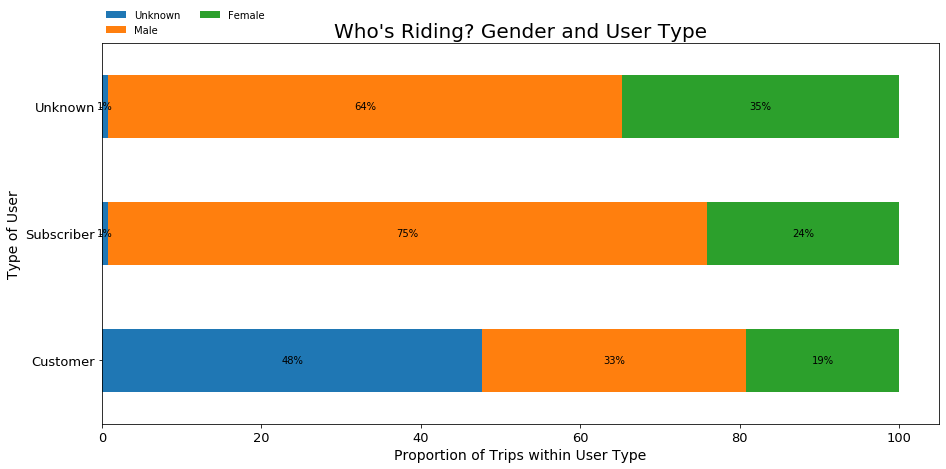

In [89]:
# 0 = Unknown, 1 = Male, 2 - Female
gender_usertype = cbacs.pivot_table('bikeid', index='usertype', columns=['gender'], aggfunc=len)
gender_usertype = gender_usertype.div(gender_usertype.sum(axis=1), axis=0).mul(100)
gender_usertype.columns = ['Unknown','Male','Female']
gender_usertype_plt = gender_usertype.plot(kind='barh', figsize=(15,7), stacked=True)
plt.xlabel('Proportion of Trips within User Type', fontsize=14)
plt.ylabel('Type of User', fontsize=14)
plt.title("Who's Riding? Gender and User Type", fontsize=20)
plt.legend(['Unknown','Male','Female'], fontsize=13)
gender_usertype_plt.legend(loc='lower left', 
                           bbox_to_anchor=(0.0, 1.01),
                           ncol=2, borderaxespad=0, frameon=False)

for p in gender_usertype_plt.patches:
    left, bottom, width, height = p.get_bbox().bounds
    gender_usertype_plt.annotate('{0:,.0f}%'.format(width), 
                                 xy=(left+width/2, bottom+height/2), 
                                 ha='center', va='center',
                                 fontsize=10)

plt.show();

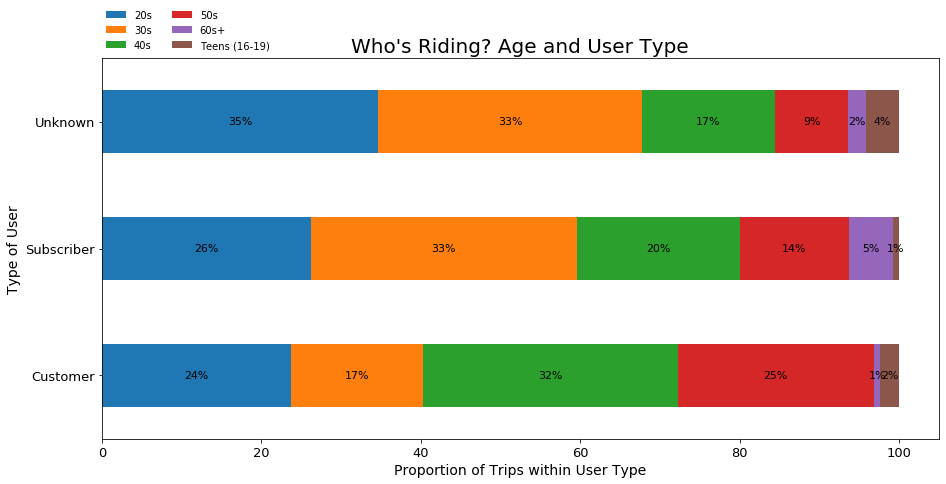

In [90]:
age_usertype = cbacs.pivot_table('bikeid', index='usertype', columns=['age_group'], aggfunc=len)
age_usertype = age_usertype.div(age_usertype.sum(axis=1), axis=0).mul(100)
age_usertype_plt = age_usertype.plot(kind='barh', figsize=(15,7), stacked=True)
plt.xlabel('Proportion of Trips within User Type', fontsize=14)
plt.ylabel('Type of User', fontsize=14)
plt.title("Who's Riding? Age and User Type", fontsize=20)
age_usertype_plt.legend(loc='lower left', bbox_to_anchor=(0.0, 1.01),
                       ncol=2, borderaxespad=0, frameon=False)

for p in age_usertype_plt.patches:
    left, bottom, width, height = p.get_bbox().bounds
    age_usertype_plt.annotate('{0:,.0f}%'.format(width), 
                              xy=(left+width/2, bottom+height/2), 
                              ha='center', va='center',
                              fontsize=11)

plt.show();

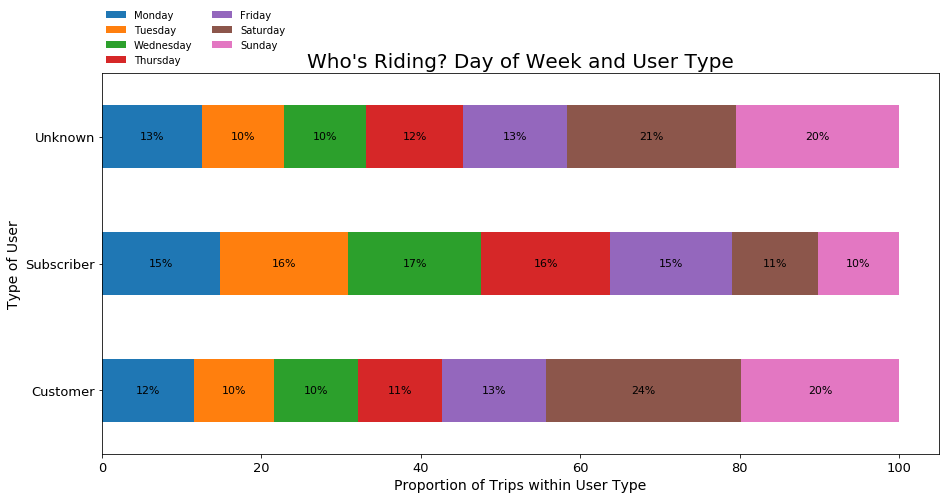

In [92]:
dayofweek_usertype = cbacs.pivot_table('bikeid', index='usertype', columns=['startdayname'], aggfunc=len)
dayofweek_usertype = dayofweek_usertype.div(dayofweek_usertype.sum(axis=1), axis=0).mul(100)
dayofweek_usertype_plt = dayofweek_usertype.plot(kind='barh', figsize=(15,7), stacked=True)
plt.xlabel('Proportion of Trips within User Type', fontsize=14)
plt.ylabel('Type of User', fontsize=14)
plt.title("Who's Riding? Day of Week and User Type", fontsize=20)
dayofweek_usertype_plt.legend(loc='lower left', bbox_to_anchor=(0.0, 1.01),
                       ncol=2, borderaxespad=0, frameon=False)

for p in dayofweek_usertype_plt.patches:
    left, bottom, width, height = p.get_bbox().bounds
    dayofweek_usertype_plt.annotate('{0:,.0f}%'.format(width), 
                              xy=(left+width/2, bottom+height/2), 
                              ha='center', va='center',
                              fontsize=11)

plt.show();

#### Route patterns

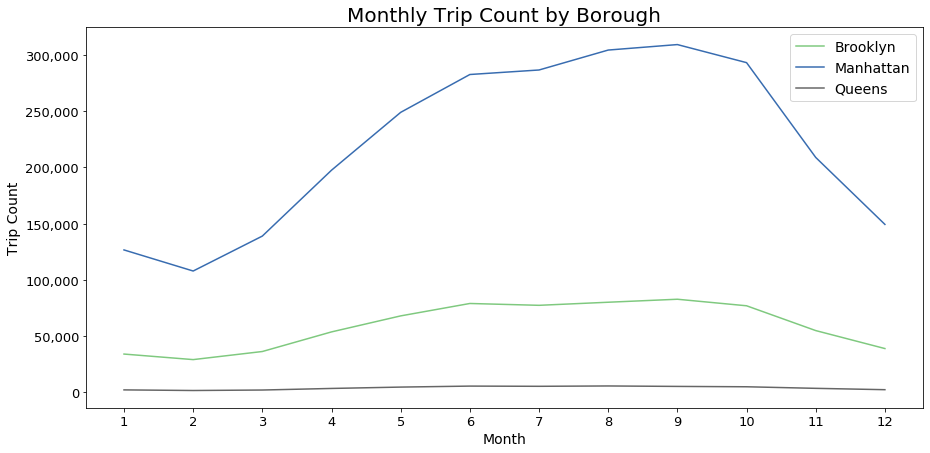

In [93]:
freq_plt = cbacs.pivot_table('bikeid', index='startmonth', columns='startboro', aggfunc='count', fill_value=0).plot(kind='line', colormap='Accent', figsize=(15,7), xticks = range(1,13))
freq_plt.yaxis.set_major_formatter(tkr.StrMethodFormatter('{x:,.0f}'))
plt.xlabel('Month', fontsize=14)
plt.ylabel('Trip Count', fontsize=14)
plt.title('Monthly Trip Count by Borough', fontsize=20)
plt.legend(['Brooklyn','Manhattan','Queens'], fontsize=14)
plt.show();

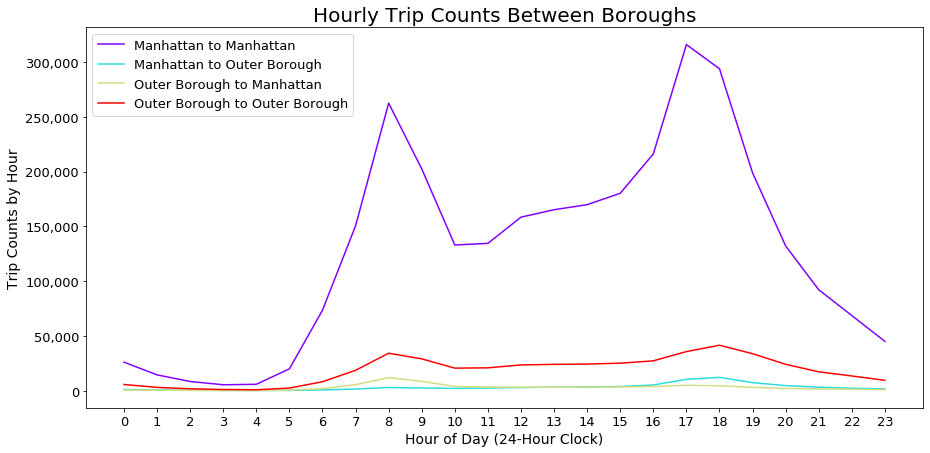

In [94]:
boro_flow = cbacs.pivot_table('bikeid', index='starthour', columns=['start_boro_flow','end_boro_flow'], aggfunc='count', fill_value=0)
boro_flow_plt = boro_flow.plot(kind='line', figsize=(15,7), xticks = range(0,24), colormap='rainbow')
boro_flow_plt.yaxis.set_major_formatter(tkr.StrMethodFormatter('{x:,.0f}'))
plt.xlabel('Hour of Day (24-Hour Clock)', fontsize=14)
plt.ylabel('Trip Counts by Hour', fontsize=14)
plt.title('Hourly Trip Counts Between Boroughs', fontsize=20)
plt.legend(['Manhattan to Manhattan','Manhattan to Outer Borough',
           'Outer Borough to Manhattan','Outer Borough to Outer Borough'], fontsize=13)
plt.show();

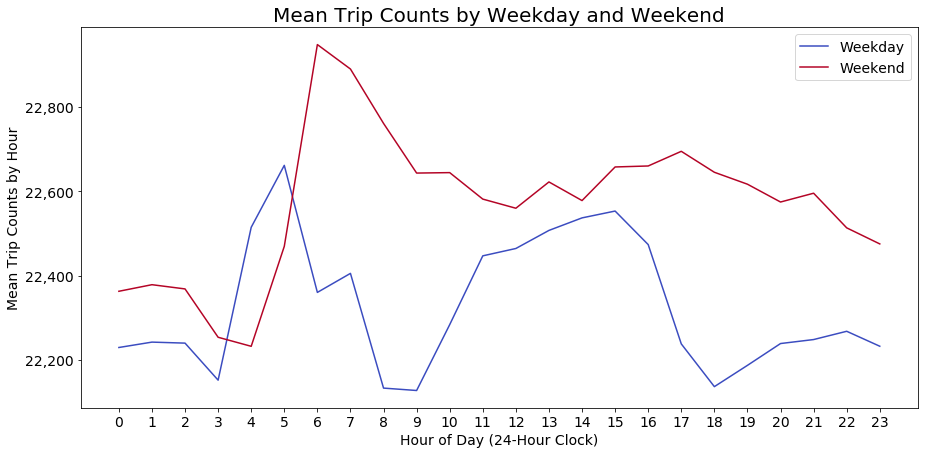

In [95]:
daytype_mean_trips = cbacs.pivot_table('bikeid', index='starthour', columns='startdaytype', aggfunc='mean')
daytype_plt = daytype_mean_trips.plot(kind='line', figsize = (15,7), xticks=range(0,24), fontsize = 14, colormap='coolwarm')
daytype_plt.yaxis.set_major_formatter(tkr.StrMethodFormatter('{x:,.0f}'))
plt.xlabel('Hour of Day (24-Hour Clock)', fontsize=14)
plt.ylabel('Mean Trip Counts by Hour', fontsize=14)
plt.title('Mean Trip Counts by Weekday and Weekend', fontsize=20)
plt.legend(['Weekday','Weekend'], fontsize=14)
plt.show();

#### Traffic Flow

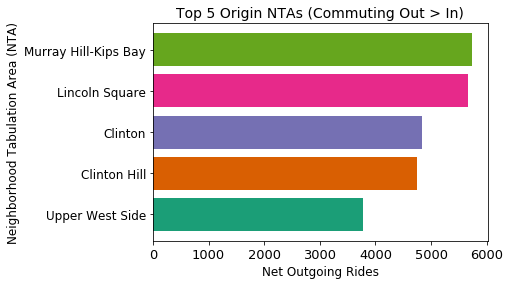

In [96]:
outf_plt = top5_nta_outflow.sort_values(['Net Outflow of Rides'], ascending=True).dropna().head(5)
outf_plt = plt.barh(range(len(outf_plt)), outf_plt['Net Outflow of Rides'], color=plt.cm.Dark2(np.arange(len(outf_plt))))
plt.yticks([4,3,2,1,0], ["Murray Hill-Kips Bay","Lincoln Square", "Clinton","Clinton Hill","Upper West Side"], fontsize=12)
plt.xlabel('Net Outgoing Rides', fontsize=12)
plt.ylabel('Neighborhood Tabulation Area (NTA)', fontsize=12)
plt.title('Top 5 Origin NTAs (Commuting Out > In)', fontsize=14) 
plt.show();

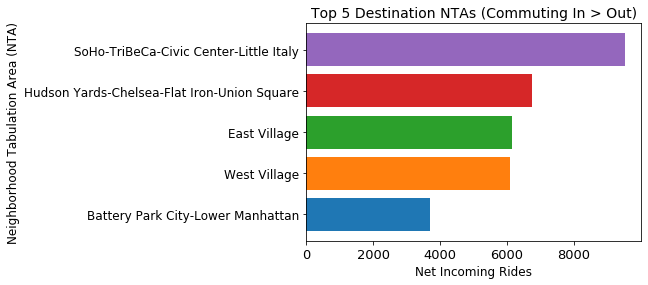

In [97]:
inf_plt = top5_nta_inflow.sort_values(['Net Inflow of Rides'], ascending=True).dropna().head(5)
inf_plt = plt.barh(range(len(inf_plt)), inf_plt['Net Inflow of Rides'], color=plt.cm.tab10(np.arange(len(inf_plt))))
plt.yticks([4,3,2,1,0], ['SoHo-TriBeCa-Civic Center-Little Italy','Hudson Yards-Chelsea-Flat Iron-Union Square',
                         'East Village','West Village','Battery Park City-Lower Manhattan'], fontsize=12)
plt.xlabel('Net Incoming Rides', fontsize=12)
plt.ylabel('Neighborhood Tabulation Area (NTA)', fontsize=12)
plt.title('Top 5 Destination NTAs (Commuting In > Out)', fontsize=14)  
plt.show();

In [98]:
chelsea_incomingt_day

stopdayname,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Neighborhood Tabulation Area,,,,,,,
Hudson Yards-Chelsea-Flat Iron-Union Square,-112,852,1145,839,1101,2050,860


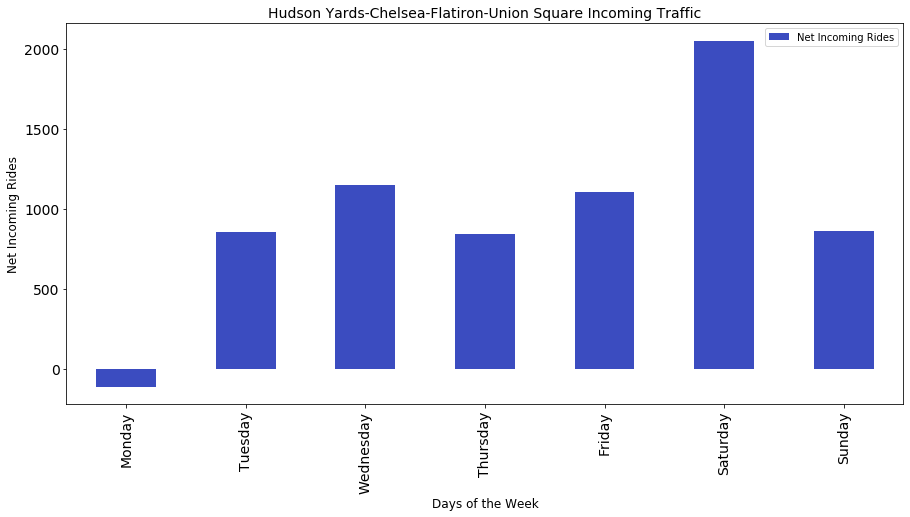

In [2]:
chelsea_incomingt_pltdf = pd.DataFrame({'Day of Week': ['Monday', 'Tuesday', 'Wednesday',
                                                       'Thursday','Friday','Saturday','Sunday'],
                                        'Net Incoming Rides': [-112, 852, 1145, 839, 1101, 2050, 860]})
chelsea_incomingt_pltdf = chelsea_incomingt_pltdf.set_index('Day of Week')
chelsea_incomingt_pltdf.plot(kind='bar',  figsize = (15,7), fontsize = 14, colormap='coolwarm')
plt.ylabel('Net Incoming Rides', fontsize=12)
plt.xlabel('Days of the Week', fontsize=12)
plt.title('Hudson Yards-Chelsea-Flatiron-Union Square Incoming Traffic', fontsize=14)  
plt.show();

In [100]:
chelsea_outgoingt_rush

startrushhour,Morning Off-Peak,Morning Rush,Afternoon Off-Peak,Afternoon Rush,Evening Off-Peak
Neighborhood Tabulation Area,,,,,
Hudson Yards-Chelsea-Flat Iron-Union Square,-143,-13139,-5432,10128,1851


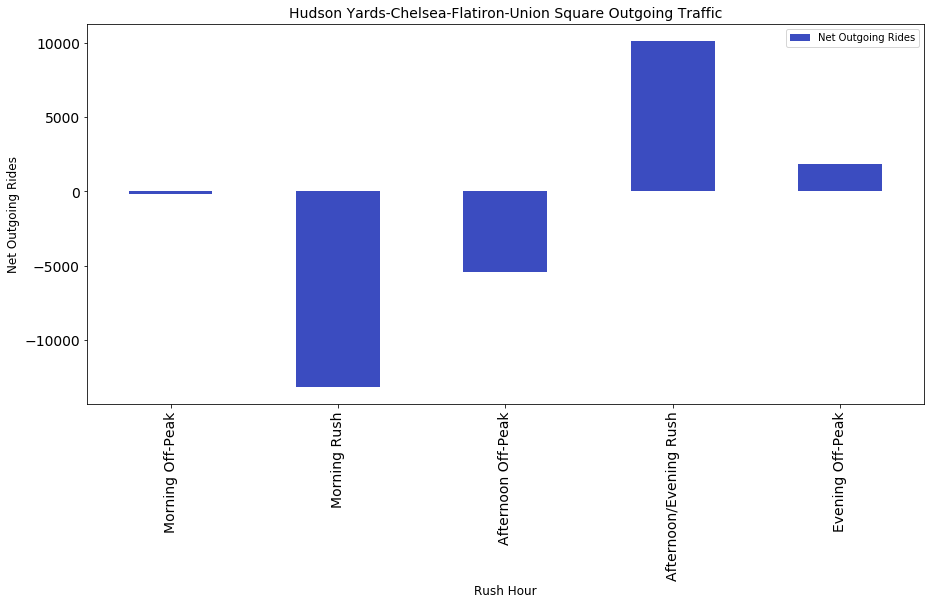

In [3]:
chelsea_outgoingt_rush_pltdf = pd.DataFrame({'Rush Hour': ['Morning Off-Peak', 'Morning Rush', 'Afternoon Off-Peak',
                                                           'Afternoon/Evening Rush','Evening Off-Peak'],
                                       'Net Outgoing Rides': [-143, -13139, -5432, 10128, 1851]})
chelsea_outgoingt_rush_pltdf = chelsea_outgoingt_rush_pltdf.set_index('Rush Hour')
chelsea_outgoingt_rush_pltdf.plot(kind='bar',  figsize = (15,7), fontsize = 14, colormap='coolwarm')
plt.ylabel('Net Outgoing Rides', fontsize=12)
plt.xlabel('Rush Hour', fontsize=12)
plt.title('Hudson Yards-Chelsea-Flatiron-Union Square Outgoing Traffic', fontsize=14)  
plt.show();

In [368]:
fordham_stats_commute_df

,nta_name,perc_car_van_truck,perc_carpool,perc_public_transit,perc_walking,perc_other_commuting_means,perc_work_at_home
10,Fordham South,0.131117,0.031878,0.704328,0.076916,0.004582,0.05118


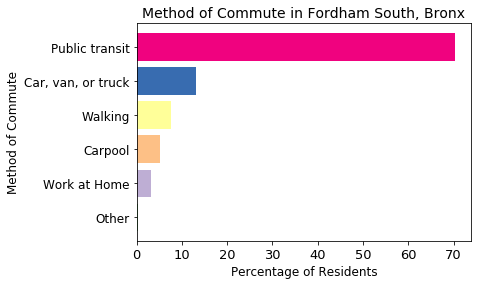

In [370]:
fordham_commute_df = pd.DataFrame({'Method of Commuting':['Car/van/truck','Carpool','Public transit',
                                    'Walking','Other','Work at Home'],
                                    'Percentage of Residents':[13.1, 3.2, 70.4, 
                                                               7.7, .4, 5.1]}).set_index('Method of Commuting').sort_values(by='Percentage of Residents')
fordham_commute_df2 = plt.barh(range(len(fordham_commute_df)), fordham_commute_df['Percentage of Residents'], color=plt.cm.Accent(np.arange(len(fordham_commute_df))))
plt.yticks([5,4,3,2,1,0], ['Public transit',"Car, van, or truck",'Walking',
                           'Carpool','Work at Home','Other'], fontsize=12)
plt.xlabel('Percentage of Residents', fontsize=12)
plt.ylabel('Method of Commute', fontsize=12)
plt.title('Method of Commute in Fordham South, Bronx', fontsize=14)  
plt.show();

In [361]:
fordham_stats_sector_df

,nta_name,perc_mng_biz_sci_arts,perc_service,perc_sales_office,perc_natres_construct_maint,perc_prod_transport_moving
10,Fordham South,0.159637,0.441744,0.22508,0.059864,0.113675


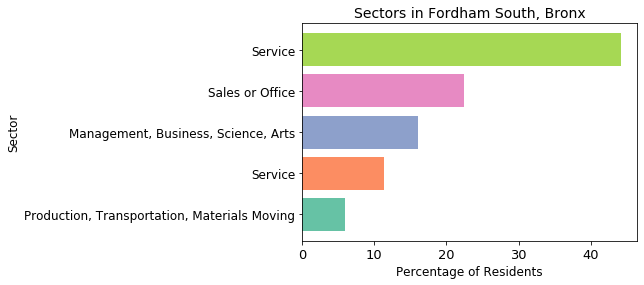

In [365]:
fordham_sector_df = pd.DataFrame({'Sector':["Management, Business, Science, Arts",
                                            "Service","Sales or Office","Natural Resources, Construction, Maintenance",
                                            "Production, Transportation, Materials Moving"],
                                    'Percentage of Residents':[16, 44.2, 22.5, 6, 11.4]}).set_index('Sector').sort_values(by='Percentage of Residents')
fordham_sector_df2 = plt.barh(range(len(fordham_sector_df)), fordham_sector_df['Percentage of Residents'], color=plt.cm.Set2(np.arange(len(fordham_sector_df))))
plt.yticks([4,3,2,1,0], ['Service','Sales or Office',"Management, Business, Science, Arts","Service",
                         "Production, Transportation, Materials Moving",
                         "Natural Resources, Construction, Maintenance"], fontsize=12)
plt.xlabel('Percentage of Residents', fontsize=12)
plt.ylabel('Sector', fontsize=12)
plt.title('Sectors in Fordham South, Bronx', fontsize=14)  
plt.show();

In [366]:
fordham_nta_stats_income_brac_df

,nta_name,perc_hincome_10K_under,perc_hincome_10K_15K,perc_hincome_15K_25K,perc_hincome_25K_35K,perc_hincome_35K_50K,perc_hincome_50K_75K,perc_hincome_75K_100K,perc_hincome_100K_150K,perc_hincome_150K_200K,perc_hincome_200K_more
10,Fordham South,0.203456,0.11204,0.172687,0.101338,0.16243,0.115496,0.076031,0.045151,0.009476,0.001895


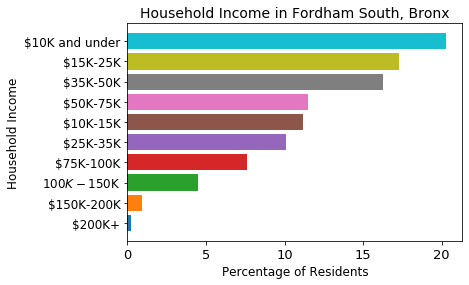

In [367]:
flatbush_hincome_df = pd.DataFrame({'Household Income':['$10K and under','$10K-15K','$15K-25K',
                                                        '$25K-35K','$35K-50K','$50K-75K','$75K-100K',
                                                      '$100K-$150K','$150K-200K','$200K+'],
                                    'Percentage of Residents':[20.3, 11.2, 17.3,10.1,16.3, 
                                                               11.5, 7.6, 4.5, .9, .2]}).set_index('Household Income').sort_values(by='Percentage of Residents')
flatbush_hincome_df2 = plt.barh(range(len(flatbush_hincome_df)), flatbush_hincome_df['Percentage of Residents'], color=plt.cm.tab10(np.arange(len(flatbush_hincome_df))))
plt.yticks([9,8,7,6,5,4,3,2,1,0], ['$10K and under','$15K-25K','$35K-50K',
                                   '$50K-75K','$10K-15K','$25K-35K','$75K-100K',
                                   '$100K-$150K','$150K-200K','$200K+'], fontsize=12)
plt.xlabel('Percentage of Residents', fontsize=12)
plt.ylabel('Household Income', fontsize=12)
plt.title('Household Income in Fordham South, Bronx', fontsize=14)  
plt.show();